**First 20 Models Simultaneous Run**

General Imports

In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_validate
from sklearn.model_selection import KFold

from sklearn.utils import all_estimators

Automatically Importing All Regressions

In [2]:
estimators = all_estimators(type_filter='regressor')

all_regs = []
for name, RegressorClass in estimators:
    try:
        if name != 'DummyRegressor' and name != 'GaussianProcessRegressor':
            print('Appending', name)
            reg = RegressorClass()
            all_regs.append(reg)
    except Exception as e:
        print(e)

Appending ARDRegression
Appending AdaBoostRegressor
Appending BaggingRegressor
Appending BayesianRidge
Appending CCA
Appending DecisionTreeRegressor
Appending ElasticNet
Appending ElasticNetCV
Appending ExtraTreeRegressor
Appending ExtraTreesRegressor
Appending GammaRegressor
Appending GradientBoostingRegressor
Appending HistGradientBoostingRegressor
Appending HuberRegressor
Appending IsotonicRegression
Appending KNeighborsRegressor
Appending KernelRidge
Appending Lars
Appending LarsCV
Appending Lasso
Appending LassoCV
Appending LassoLars
Appending LassoLarsCV
Appending LassoLarsIC
Appending LinearRegression
Appending LinearSVR
Appending MLPRegressor
Appending MultiOutputRegressor
__init__() missing 1 required positional argument: 'estimator'
Appending MultiTaskElasticNet
Appending MultiTaskElasticNetCV
Appending MultiTaskLasso
Appending MultiTaskLassoCV
Appending NuSVR
Appending OrthogonalMatchingPursuit
Appending OrthogonalMatchingPursuitCV
Appending PLSCanonical
Appending PLSRegress

Load and Describe Data

In [3]:
def load_pp_data():
    csv_path = r"C:\Users\18123\OneDrive\Documents\IU Bloomington\Machine-Learning-Project\PowerPlantData\CCPP\Folds5x2_pp.csv"
    return pd.read_csv(csv_path)

pp = load_pp_data()
print(pp.describe())

                AT            V           AP           RH           PE
count  9568.000000  9568.000000  9568.000000  9568.000000  9568.000000
mean     19.651231    54.305804  1013.259078    73.308978   454.365009
std       7.452473    12.707893     5.938784    14.600269    17.066995
min       1.810000    25.360000   992.890000    25.560000   420.260000
25%      13.510000    41.740000  1009.100000    63.327500   439.750000
50%      20.345000    52.080000  1012.940000    74.975000   451.550000
75%      25.720000    66.540000  1017.260000    84.830000   468.430000
max      37.110000    81.560000  1033.300000   100.160000   495.760000


Train/Test Split and Preprocess Data

In [4]:
pp["AT_cat"] = pd.cut(pp["AT"],bins=[0.,10.,20.,30.,np.inf],labels=[1,2,3,4])

split = StratifiedShuffleSplit(n_splits=1,test_size=0.2,random_state=42)
for train_index, test_index in split.split(pp,pp["AT_cat"]):
    train_set = pp.loc[train_index]
    test_set = pp.loc[test_index]

for set_ in(train_set,test_set):
    set_.drop("AT_cat",axis=1,inplace=True)

pptrain = train_set.copy()
pptest = test_set.copy()

pptrain_attrib = pptrain.drop("PE",axis=1)
pptrain_labels = pptrain["PE"].copy()
pptest_attrib = pptest.drop("PE",axis=1)
pptest_labels = pptest["PE"].copy()

scaler = StandardScaler()
scaler.fit_transform(pptrain_attrib)

array([[ 1.1978498 ,  0.96554795,  0.37377565, -2.67409022],
       [ 0.64009018, -1.03750958, -1.88469509, -2.35340963],
       [-1.82211612, -1.45609422, -0.36887464,  1.17611946],
       ...,
       [-1.07754063, -0.84989538,  0.57724148,  0.20454577],
       [-0.67971691, -0.96104497,  0.78748951,  0.87314098],
       [ 0.89545   ,  0.56351752, -0.13658448, -1.12107019]])

Simultaneous Run

c:\Users\18123\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\linear_model\_huber.py:335: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\Users\18123\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\linear_model\_base.py:133: FutureWarning: The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), Lars())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follow

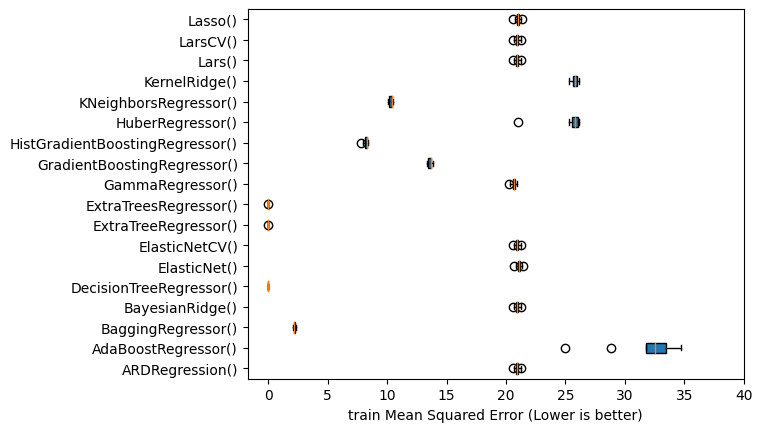

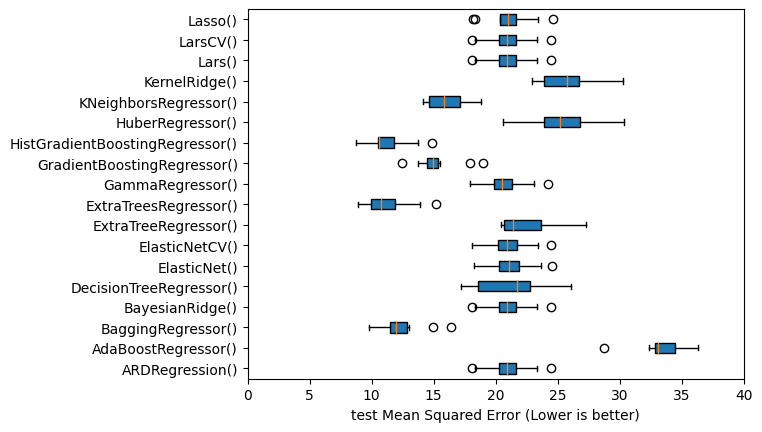

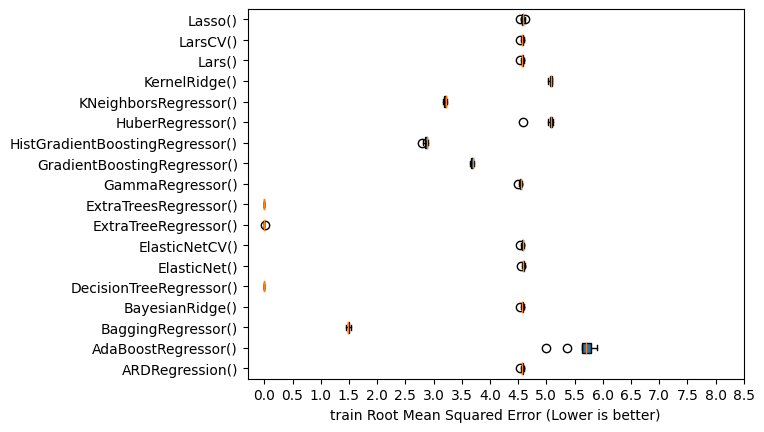

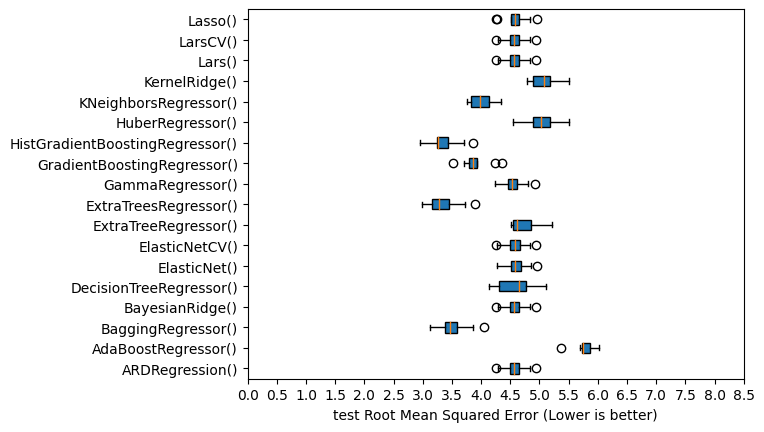

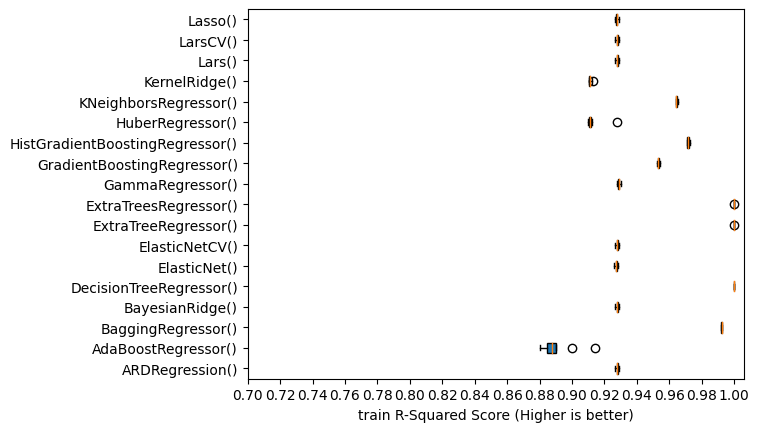

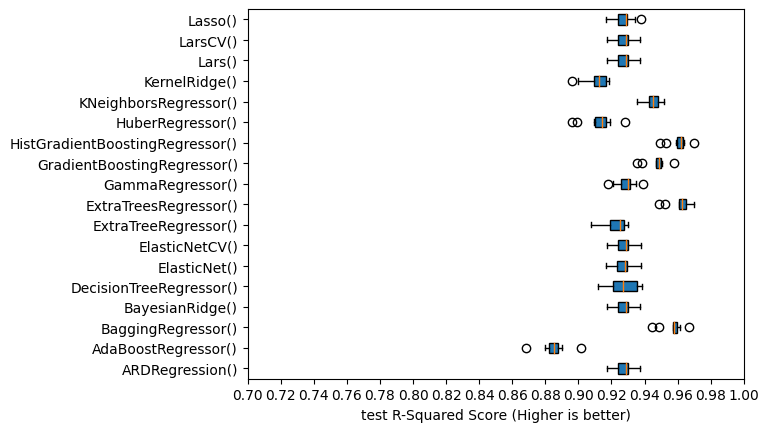

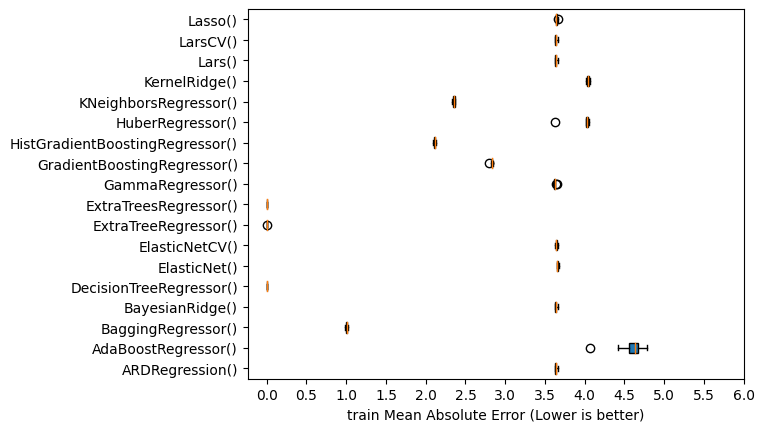

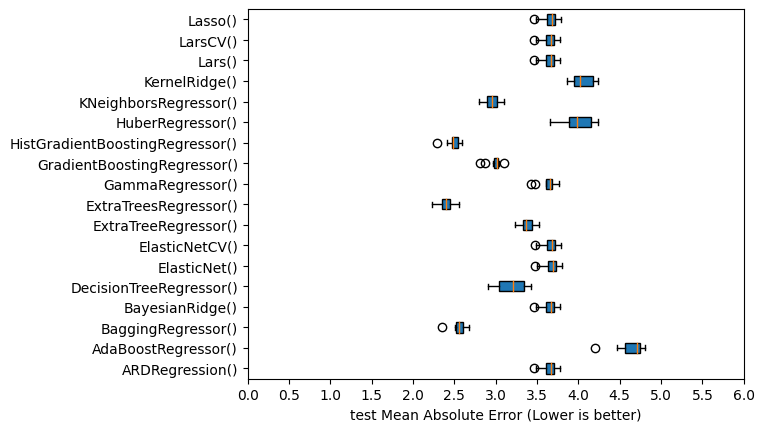

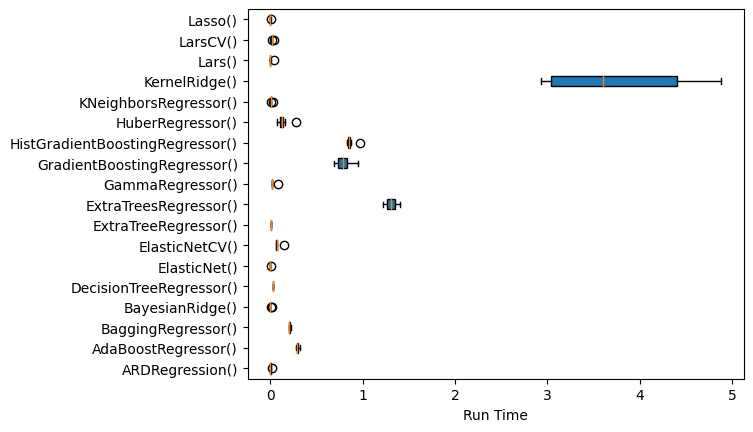

In [5]:
def run(model):
    try:
        cv_outer = KFold(n_splits=10, shuffle=True, random_state=2)
        cv_output_dict = cross_validate(model, pptrain_attrib, pptrain_labels, scoring=["neg_mean_squared_error","neg_mean_absolute_error","r2"], cv=cv_outer, return_train_score=True, return_estimator=True)
        return cv_output_dict    
    except:
        pass

def comparison(modellst):
    cv_data = []
    errors = []
    passed_models = []
    for i in range(len(modellst)):
        x = run(modellst[i])
        if type(x) == dict:
            cv_data += [x]
        else:
            errors += [i]
    for j in range(len(modellst)):
        if j not in errors:
            passed_models += [modellst[j]]       
    return vizualize(cv_data, passed_models)

def vizualize(cv_data, modellst):
    return box_mse(cv_data, modellst,'train'), box_mse(cv_data, modellst, 'test'), box_rmse(cv_data, modellst, 'train'), box_rmse(cv_data, modellst, 'test'), box_r2(cv_data, modellst, 'train'), box_r2(cv_data, modellst, 'test'), box_mae(cv_data, modellst, 'train'), box_mae(cv_data, modellst, 'test'), runtime(cv_data, modellst)

def runtime(cv_data, modellst):
    timefig = plt.figure()
    x = []
    for i in cv_data:
        x += [i['fit_time']]
    plt.boxplot(x,vert=False,patch_artist=True,labels=[*modellst])
    xticklst = []
    for j in range(0,10):
        xticklst += [j/1000]    
    plt.xlabel('Run Time')
    return timefig

def box_mse(cv_data, modellst, data_split):
    MSEfig = plt.figure()
    x = []
    for i in cv_data:
        x += [i[data_split+'_neg_mean_squared_error']*-1]
    plt.boxplot(x,vert=False,patch_artist=True,labels=[*modellst])
    plt.xticks([*range(0,45,5)])
    plt.xlabel(f'{data_split} Mean Squared Error (Lower is better)')
    return MSEfig

def box_rmse(cv_data, modellst, data_split):
    RMSEfig = plt.figure()
    x = []
    for i in cv_data:
        x += [np.sqrt(i[data_split+'_neg_mean_squared_error']*-1)]
    plt.boxplot(x,vert=False,patch_artist=True,labels=[*modellst])
    xticklst = []
    for j in range(0,90,5):
        xticklst += [j/10]
    plt.xticks(xticklst)
    plt.xlabel(f'{data_split} Root Mean Squared Error (Lower is better)')
    return RMSEfig

def box_r2(cv_data, modellst, data_split):
    R2fig = plt.figure()
    x = []
    for i in cv_data:
        x += [i[data_split+'_r2']]
    plt.boxplot(x,vert=False,patch_artist=True,labels=[*modellst])
    xticklst = []
    for j in range(70,102,2):
        xticklst += [j/100]
    plt.xticks(xticklst)
    plt.xlabel(f'{data_split} R-Squared Score (Higher is better)')
    return R2fig

def box_mae(cv_data, modellst, data_split):
    MAEfig = plt.figure()
    x = []
    for i in cv_data:
        x += [i[data_split+'_neg_mean_absolute_error']*-1]
    plt.boxplot(x,vert=False,patch_artist=True,labels=[*modellst])
    xticklst = []
    for j in range(0,650,50):
        xticklst += [j/100]
    plt.xticks(xticklst)
    plt.xlabel(f'{data_split} Mean Absolute Error (Lower is better)')
    return MAEfig

y = all_regs[0:20]
x = all_regs[0:3]
comparison(y)
plt.show()